# Introduction

The idea of Rainbow is to glue together all the most classical DQN-extensions.

## Importing Section

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math, random
import numpy as np
import matplotlib.pyplot as plt

import gym

from IPython.display import clear_output
from wrap import make_atari, wrap_deepmind, wrap_pytorch
from collections import deque

In [2]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
env    = gym.wrappers.Monitor(env, "./vid" , video_callable=lambda episode_id: (episode_id+1)%10==0, force = True)

## Device Selection

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

## Noisy DQN Part

In [4]:
class NoisyNet(nn.Module):
    def __init__(self, in_features, out_features, std = 0.4):
        super(NoisyNet, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std = std
        
        self.weights_mu = nn.Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.weights_sigma = nn.Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.register_buffer('weight_noise', torch.FloatTensor(self.out_features, self.in_features))
        
        self.bias_mu = nn.Parameter(torch.FloatTensor(self.out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(self.out_features))
        self.register_buffer('bias_noise', torch.FloatTensor(self.out_features))
        
        self.initialize_parameters()
        self.reset_noise()
        
    def initialize_parameters(self):
        alpha = math.sqrt(self.in_features)
        mu_range = 1.0/alpha
        
        self.weights_mu.data.uniform_(-mu_range, mu_range)
        self.weights_sigma.data.fill_(self.std/ alpha)
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std/ math.sqrt(self.out_features))
        
    def reset_noise(self):
        noise_in = self._generate_noise(self.in_features)
        noise_out = self._generate_noise(self.out_features)
        
        noise = noise_out.ger(noise_in)
        self.weight_noise.copy_(noise)
        self.bias_noise.copy_(self._generate_noise(self.out_features))
    
    def _generate_noise(self, size):
        noise = torch.randn(size)
        final_noise = noise.sign().mul(noise.abs().sqrt())
        return noise 
    
    def forward(self, state):
        if self.training == True:
            weight = self.weights_mu + self.weights_sigma.mul(self.weight_noise)
            bias = self.bias_mu + self.bias_sigma.mul(self.bias_noise)           
        else:
            weight = self.weight_mu
            bias = self.bias_mu
            
        return F.linear(state, weight, bias)

## Prio-Replay-Buffer

In [5]:
class Buffer():
    def __init__(self, capacity, batch_size, alpha_prob = 0.6):
        self.capacity = capacity
        self.alpha_prob = alpha_prob
        self.batch_size = batch_size
        self.buffer = []
        self.priorities = np.zeros(self.capacity, dtype = np.float32)
        self.pos = 0
        
    def push(self, state, action, reward, next_state, is_done):
        state = np.expand_dims(state, axis = 0)
        next_state = np.expand_dims(next_state, axis = 0)
        
        max_prio = 1.0 if len(self.buffer) == 0 else self.priorities.max()
        # PRINTARE MAX_PRIO
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, is_done))
            self.priorities[self.pos] = max_prio
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, is_done)
            self.priorities[self.pos] = max_prio
            
        self.pos = (self.pos + 1)%self.capacity
        
    def sample(self, beta = 0.4): 
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        #print(prios)
        probs = prios ** self.alpha_prob
        probs = probs/probs.sum()
        #print(probs)
        indices = np.random.choice(len(self.buffer), self.batch_size, p = probs)
        # selecting elements
        sample = [self.buffer[idx] for idx in indices]
        
        states, actions, rewards, next_states, is_dones = zip(*sample)
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights = weights/weights.max()
        weights = np.asarray(weights, dtype = np.float32)
        
        return states, actions, rewards, next_states, is_dones, weights, indices
    
    def update_priorities(self, indices, new_prios):
        for idx, new_prio in zip(indices, new_prios):
            self.priorities[idx] = new_prio
            
    def __len__(self):
        return len(self.buffer)

## Beta Function for Experience Replay Buffer

In [6]:
def beta_decay_f(iteration, beta_init = 0.4, stop_after = 100000):
    beta = min(1.0, beta_init + iteration * (1.0 - beta_init)/stop_after)
    return beta

## Hyper-Parameters Related to the Distributional DQN part of the code

In [7]:
V_min = -10
V_max = 10
num_atoms = 51

## Distributional DQN Part

In [8]:
def projection_distribution(next_states, rewards, is_dones, tg_agent, agent):
    batch_size = next_states.size(0)
    
    delta_z = float(V_max - V_min)/(num_atoms - 1)
    
    # Here comes DDQN Part: We evaluate the action with
    
    support = torch.linspace(V_min, V_max, num_atoms).to(device)
    next_dist = agent(next_states)
    
    DDQN_actions = next_dist*support
    DDQN_action = DDQN_actions.sum(2).max(1)[1]
    DDQN_action = DDQN_action.unsqueeze(1).unsqueeze(1).expand(DDQN_actions.size(0),1,DDQN_actions.size(2))
    
    next_dist = tg_agent(next_states)
    next_dist = next_dist.gather(1, DDQN_action).squeeze(1)
    
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    is_dones = is_dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    #print(rewards.size())
    #print(support.size())
    Tz = rewards + (1.0 - is_dones) * 0.99 * support
    #print('TZ', Tz.size())
    Tz = Tz.clamp(min = V_min, max = V_max)
    b = (Tz - V_min)/delta_z
    #print(b)
    #print('B', b.size())
    l = b.floor().long()
    u = b.ceil().long()
    
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long().unsqueeze(1).expand(batch_size, num_atoms).to(device)
    #print('OFFSET', offset.size())
    proj_dist = torch.zeros(next_dist.size()).to(device)
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
    
    return proj_dist
    

## Loss Function

In [9]:
def Loss(agent, tg_agent, buffer, beta, device, optimizer):
    states, actions, rewards, next_states, is_dones, weights, indices = buffer.sample(beta)
    
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    is_dones = torch.FloatTensor(is_dones).to(device)
    
    weights = torch.FloatTensor(weights).to(device)
    
    proj_dist = projection_distribution(next_states, rewards, is_dones, tg_agent, agent)
    dist = agent(states)
    actions = actions.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, actions).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    
    loss = -(proj_dist.detach() * dist.log()).sum(1)
    new_prios = (loss + 1e-5).pow(2)
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    buffer.update_priorities(indices, new_prios.data.cpu().numpy())
    
    return loss

## Update Target

In [10]:
def update(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

## Plotting

In [11]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Agent

In [12]:
class Agent(nn.Module):
    def __init__(self, observation_space, action_space, num_atoms, Vmin, Vmax, device):
        super(Agent, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.num_atoms = num_atoms
        self.Vmin = Vmin
        self.Vmax = Vmax
        self.device = device
        
        self.feat_extractor = nn.Sequential(
            nn.Conv2d(self.observation_space[0], 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU())
        
        self.noisyvalue1 = NoisyNet(self.get_size_img(), 512)
        self.noisyvalue2 = NoisyNet(512, self.num_atoms)
        
        self.noisyadvantage1 = NoisyNet(self.get_size_img(), 512)
        self.noisyadvantage2 = NoisyNet(512, self.action_space*self.num_atoms)
        
    def get_size_img(self):
        img_ex = torch.zeros(self.observation_space).unsqueeze(0)
        size_tuple = self.feat_extractor(img_ex)
        size = np.prod(size_tuple.size())
        return size
    
    def reset_noise(self):
        self.noisyvalue1.reset_noise()
        self.noisyvalue2.reset_noise()
        
        self.noisyadvantage1.reset_noise()
        self.noisyadvantage2.reset_noise()
        
    def forward(self,state):
        batch_size = state.size(0)
        state = state/255.0
        state = self.feat_extractor(state)
        state = state.view(batch_size, -1)
        
        value = F.relu(self.noisyvalue1(state))
        value = self.noisyvalue2(value).view(batch_size, 1, self.num_atoms)
        
        advantage = F.relu(self.noisyadvantage1(state))
        advantage = self.noisyadvantage2(advantage).view(batch_size, self.action_space, self.num_atoms)
        
        # Prossimo elemento c'e' da fare un check perche' non capisco dove sta facendo la media
        output = value + advantage - advantage.mean(1, keepdim = True)
        output = F.softmax(output.view(batch_size*self.action_space, -1)).view(batch_size, self.action_space, self.num_atoms)
        
        return output
    
    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        output = self.forward(state)
        values = torch.linspace(self.Vmin, self.Vmax, self.num_atoms).to(self.device)
        weights = output*values
        action = weights.sum(2).max(1)[1].detach().cpu().numpy()[0]
        return action

## Training Function

In [13]:
def training ( agent, tg_agent, buffer, env, device, num_episodes, batch_size, plot_every, update_net_every ):
    losses = []
    episodes_rewards = []
    episode_rew = 0
    ep = 1
    
    state = env.reset()
    num_iterations = 0 # Useful for epsilon_decay
    
    while ep <= num_episodes:
        action = agent.act(state) 
        
        next_state, reward, is_done, _ = env.step(action)
        buffer.push(state, action, reward, next_state, is_done)
        
        episode_rew += reward
        state = next_state
        num_iterations += 1
        
        if is_done == True:
            #print(episode_rew)
            episodes_rewards.append(episode_rew)
            episode_rew = 0
            ep += 1
            state = env.reset()
        
        if len(buffer) > 100:
            #print('AAAAAAAAAAAAA')
            loss = Loss(agent, tg_agent, buffer, batch_size, device, optimizer)
            losses.append(loss)
            
        if num_iterations % plot_every == 0:
            #print(num_iterations)
            plot(num_iterations, episodes_rewards, losses)
            
        if num_iterations % update_net_every == 0:
            #print('UPDATE')
            update(agent, tg_agent)
            
        if num_iterations % 40 == 0:
            agent.reset_noise()
            
            tg_agent.reset_noise()
            
        ep+=1
            

In [14]:
# Instatiating Object

agent = Agent(env.observation_space.shape, env.action_space.n, num_atoms, V_min, V_max, device).to(device)
tg_agent = Agent(env.observation_space.shape, env.action_space.n, num_atoms, V_min, V_max, device).to(device)
update(agent, tg_agent)
optimizer = optim.Adam(agent.parameters(), lr = 0.00005)

capacity = 100000
batch_size = 32

buffer = Buffer(capacity, batch_size)

num_episodes = 250

plot_every = 200
update_net_every = 100

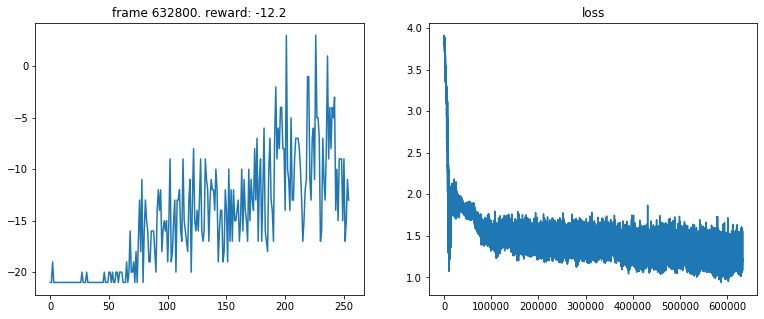

KeyboardInterrupt: 

In [15]:
training(agent, tg_agent, buffer, env, device, 2000, batch_size, plot_every, update_net_every)